In [398]:
import tensorflow as tf
import os
import numpy as np
import glob
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, initializers
from tensorflow.keras.layers import ZeroPadding2D
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import joblib
from utils.plot_map import plot_feature_on_map
from datetime import datetime

In [ ]:
data_path = "../../../../../../../Volumes/T7 Shield/preprocessed_new_exp1_full"
# data_path = "../../data/preprocessed_new"

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
# for results,model and scaler
folder_path = "../plots/u-next/" + timestamp
os.makedirs(folder_path, exist_ok=True)

feature_files = [os.path.join(data_path, f"{i}_features.npy") for i in range(1, 733)]
target_files = [os.path.join(data_path, f"{i}_targets.npy") for i in range(1, 733)]

features = np.stack([np.load(fp) for fp in feature_files])
targets = np.stack([np.load(fp) for fp in target_files])
  
targets = targets[..., 2]

print(targets.shape)
print(features.shape)

In [ ]:
mask = features[..., 11] == 0 
# setting this feature to zero for land points because it had some random values
features[..., 5][mask] = 0 

In [ ]:
X_train = features[:int(0.8 * len(features))]
Y_train = targets[:int(0.8 * len(targets))]
X_val = features[int(0.8 * len(features)):int(0.9 * len(features))]
Y_val = targets[int(0.8 * len(targets)):int(0.9 * len(targets))]
X_test = features[int(0.9 * len(features)):]
Y_test = targets[int(0.9 * len(targets)):]

scaler = MinMaxScaler()
n_samples, h, w, n_features = X_train.shape
X_train_flat = X_train.reshape(-1,n_features)
X_train_scaled_flat = scaler.fit_transform(X_train_flat)
X_train = X_train_scaled_flat.reshape(n_samples, h, w, n_features)


n_samples, h, w, n_features = X_val.shape
X_val_flat = X_val.reshape(-1,n_features)
X_val_scaled_flat = scaler.transform(X_val_flat)
X_val = X_val_scaled_flat.reshape(n_samples, h, w, n_features)

n_samples, h, w, n_features = X_test.shape
X_test_flat = X_test.reshape(-1,n_features)
X_test_scaled_flat = scaler.transform(X_test_flat)
X_test = X_test_scaled_flat.reshape(n_samples, h, w, n_features)

joblib.dump(scaler, folder_path + '/scaler.pkl')

['../plots/u-next/2025-06-09_14-18/scaler.pkl']

In [ ]:
# Depthwise convolution used inside ShiftMLP
class DepthwiseConv(tf.keras.layers.Layer):
    def __init__(self, dim):
        super().__init__()
        self.dwconv = layers.DepthwiseConv2D(kernel_size=3, padding='same')

    def call(self, x, *, H, W):
        B = tf.shape(x)[0]
        N = tf.shape(x)[1]
        C = tf.shape(x)[2]
        x = tf.transpose(x, [0, 2, 1])
        x = tf.reshape(x, [B, C, H, W])
        x = tf.transpose(x, [0, 2, 3, 1])
        x = self.dwconv(x)
        x = tf.transpose(x, [0, 3, 1, 2])
        x = tf.reshape(x, [B, C, H * W])
        x = tf.transpose(x, [0, 2, 1])
        return x

# MLP with shift operation
class ShiftMLP(tf.keras.layers.Layer):
    def __init__(self, dim, shift_size=4, dropout=0.0):
        super().__init__()
        self.dim = dim
        self.shift_size = shift_size
        self.pad = shift_size // 2
        self.fc1 = layers.Dense(dim)
        self.dwconv = DepthwiseConv(dim)
        self.act = layers.Activation('relu')
        self.fc2 = layers.Dense(dim)
        self.dropout = layers.Dropout(dropout)

    def shift(self, x, *, H, W, axis):
        x = tf.transpose(x, [0, 2, 1])
        x = tf.reshape(x, [-1, self.dim, H, W])
        x = tf.pad(x, [[0, 0], [0, 0], [self.pad, self.pad], [self.pad, self.pad]])
        x = tf.transpose(x, [0, 2, 3, 1])
        splits = tf.split(x, self.shift_size, axis=-1)
        shifts = [tf.roll(s, shift, axis=axis) for s, shift in zip(splits, range(-self.pad, self.pad + 1))]
        x = tf.concat(shifts, axis=-1)
        x = x[:, self.pad:self.pad + H, self.pad:self.pad + W, :]
        x = tf.reshape(x, [-1, H * W, self.dim])
        return tf.transpose(x, [0, 2, 1])

    def call(self, x, *, H, W):
        x = self.shift(x, H=H, W=W, axis=1)
        x = tf.transpose(x, [0, 2, 1])
        x = self.fc1(x)
        x = self.dwconv(x, H=H, W=W)
        x = self.act(x)
        x = self.dropout(x)
        x = tf.transpose(x, [0, 2, 1])
        x = self.shift(x, H=H, W=W, axis=2)
        x = tf.transpose(x, [0, 2, 1])
        x = self.fc2(x)
        x = self.dropout(x)
        return x

# One shifted block
class ShiftedBlock(tf.keras.layers.Layer):
    def __init__(self, dim, drop_path=0.0):
        super().__init__()
        self.norm = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = ShiftMLP(dim)
        self.drop_path = layers.Dropout(drop_path)

    def call(self, x, *, H, W):
        res = x
        x = self.norm(x)
        x = self.mlp(x, H=H, W=W)
        return res + self.drop_path(x)

# Patch embedding layer
class OverlapPatchEmbed(tf.keras.layers.Layer):
    def __init__(self, patch_size=7, stride=4, embed_dim=768):
        super().__init__()
        self.proj = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=stride, padding='same')
        self.norm = layers.LayerNormalization(epsilon=1e-6)

    def call(self, x):
        x = self.proj(x)
        B, H, W, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]
        x = tf.reshape(x, [B, H * W, C])
        x = self.norm(x)
        return x, H, W


def build_unext(input_shape=(167, 360, 16)):
    inputs = layers.Input(shape=input_shape)

    # Encoder Block 1
    x1 = layers.Conv2D(32, 3, padding='same')(inputs)        # (160, 360, 16)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.ReLU()(x1)
    p1 = layers.MaxPooling2D()(x1)                           # (80, 180, 16)

    # Encoder Block 2
    x2 = layers.Conv2D(64, 3, padding='same')(p1)            # (80, 180, 32)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.ReLU()(x2)
    p2 = layers.MaxPooling2D()(x2)                           # (40, 90, 32)

    # Encoder Block 3
    x3 = layers.Conv2D(128, 3, padding='same')(p2)           # (40, 90, 128)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.ReLU()(x3)
    p3 = layers.MaxPooling2D()(x3)                           # (20, 45, 128)

    # MLP Block 1
    patch_embed1 = OverlapPatchEmbed(patch_size=3, stride=2, embed_dim=160)
    x4, _, _ = patch_embed1(p3)                              # (B, 900, 160) from (20x45)
    x4 = ShiftedBlock(160)(x4, H=10, W=23)
    x4 = layers.LayerNormalization()(x4)
    x4 = layers.Reshape((10, 23, 160))(x4)

    # MLP Block 2 (Bottleneck)
    patch_embed2 = OverlapPatchEmbed(patch_size=3, stride=2, embed_dim=256)
    x5, _, _ = patch_embed2(x4)                              # (B, 900, 256)
    x5 = ShiftedBlock(256)(x5, H=5, W=12)
    x5 = layers.LayerNormalization()(x5)
    x5 = layers.Reshape((5, 12, 256))(x5)

    # Decoder Block 1
    x = layers.Conv2D(160, 3, padding='same')(x5)             # (5, 12, 160)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D()(x)                            # (10, 24, 160)
    x = layers.ReLU()(x)
    x = layers.Cropping2D(((0, 0), (1, 0)))(x)               # (10, 23, 160)
    x = layers.Add()([x, x4])                                # (10, 23, 160)
    # x = tf.reshape(x, [-1, 10 * 23, 160])
    x = layers.Reshape((-1, 160))(x) 
    x = ShiftedBlock(160)(x, H=10, W=23)
    x = layers.LayerNormalization()(x)
    x = layers.Reshape((10, 23, 160))(x)

    # Decoder Block 2
    x = layers.Conv2D(128, 3, padding='same')(x)             # (10, 23, 128)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D()(x)                             # (20, 46, 128)
    x = layers.ReLU()(x)
    x = layers.Cropping2D(((0, 0), (1, 0)))(x)              # (20, 45, 128) 
    x = layers.Add()([x, p3])       
    # x = tf.reshape(x, [-1, 20 * 45, 160])    
    x = layers.Reshape((-1, 128))(x)                  
    x = ShiftedBlock(128)(x, H=20, W=45)
    x = layers.LayerNormalization()(x)
    x = layers.Reshape((20, 45, 128))(x)

    # Decoder Block 3
    x = layers.Conv2D(64, 3, padding='same')(x)              # (20, 45, 64)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D()(x)                             # (40, 90, 64)
    x = layers.ReLU()(x)
    x_padded = ZeroPadding2D(((1, 0), (0, 0)))(x)  
    x = layers.Add()([x_padded, p2])                               # (41,90,64)

    # Decoder Block 4
    x = layers.Conv2D(32, 3, padding='same')(x)              # (41, 90, 32)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D()(x)                             # (82, 180, 32)
    x = layers.ReLU()(x)
    x_padded = ZeroPadding2D(((1, 0), (0, 0)))(x)  
    x = layers.Add()([x_padded, p1])                               # (83, 180, 32)

    # Decoder Block 5
    x = layers.Conv2D(32, 3, padding='same')(x)              # (83, 180, 32)
    x = layers.UpSampling2D()(x)                             # (166, 360, 32)
    x = ZeroPadding2D(((1, 0), (0, 0)))(x)                  # (167, 360, 32)
    x = layers.ReLU()(x)

    # Output layer
    output = layers.Conv2D(1, 1, activation='linear')(x)     # (167, 360, 1)
    masked_outputs = layers.Lambda(lambda x: x[0] * tf.expand_dims(x[1][:, :, :, 11], axis=-1))([output, inputs])

    return models.Model(inputs, masked_outputs)



In [ ]:
lr = 0.0001
loss_function = 'Huber(delta=2.0)'
batch_size = 4

model = build_unext(input_shape=(167, 360, 16))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.Huber(delta=2.0), metrics=['mae'])
model.summary()

Model: "functional_78"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_142     │ (None, 167, 360,  │          0 │ -                 │
│ (InputLayer)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_387 (Conv2D) │ (None, 167, 360,  │      4,640 │ input_layer_142[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 167, 360,  │        128 │ conv2d_387[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_282 (ReLU)    │ (None, 167, 360,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_213   │ (None, 83, 180,   │          0 │ re_lu_282[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_388 (Conv2D) │ (None, 83, 180,   │     18,496 │ max_pooling2d_21… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 83, 180,   │        256 │ conv2d_388[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_283 (ReLU)    │ (None, 83, 180,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_214   │ (None, 41, 90,    │          0 │ re_lu_283[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_389 (Conv2D) │ (None, 41, 90,    │     73,856 │ max_pooling2d_21… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 41, 90,    │        512 │ conv2d_389[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_284 (ReLU)    │ (None, 41, 90,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_215   │ (None, 20, 45,    │          0 │ re_lu_284[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ overlap_patch_embe… │ [(None, 230,      │    184,800 │ max_pooling2d_21… │
│ (OverlapPatchEmbed) │ 160), (), ()]     │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shifted_block_109   │ (None, 230, 160)  │     53,440 │ overlap_patch_em… │
│ (ShiftedBlock)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 230, 160)  │        320 │ shifted_block_10… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_91          │ (None, 10, 23,    │          0 │ layer_normalizat

 Total params: 1,585,921 (6.05 MB)

 Trainable params: 1,584,705 (6.05 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train,
    Y_train,
    validation_data=(X_val, Y_val),
    batch_size=batch_size,  
    epochs=20,  # Number of training epochs
    callbacks=[lr_scheduler, early_stopping],
)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 224ms/step - loss: 0.4865 - mae: 0.6294 - val_loss: 0.5601 - val_mae: 0.6646 - learning_rate: 1.0000e-04
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 217ms/step - loss: 0.2078 - mae: 0.3761 - val_loss: 0.5947 - val_mae: 0.6641 - learning_rate: 1.0000e-04
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 207ms/step - loss: 0.1647 - mae: 0.3291 - val_loss: 0.5013 - val_mae: 0.5954 - learning_rate: 1.0000e-04
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - loss: 0.1343 - mae: 0.2934 - val_loss: 0.3888 - val_mae: 0.5175 - learning_rate: 1.0000e-04
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 204ms/step - loss: 0.1218 - mae: 0.2781 - val_loss: 0.2557 - val_mae: 0.4088 - learning_rate: 1.0000e-04
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 205ms/step - loss: 0.1158 - mae: 0.2700 - val_loss: 0.1839 - val_mae: 0.3402 - learning_rate: 1.0000e-04
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 205ms/step - loss: 0.1065 - mae: 0.2576 - val_loss: 0.1499 - val_mae: 0.3046

In [ ]:
model.save(folder_path + "/model.keras")

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

test_pred = model.predict(X_test)
pred = test_pred.reshape(-1)
truth = Y_test.reshape(-1)

# test_pred = target_scaler.inverse_transform(test_pred)

# computiung mse and mae for ocean points only
mask = X_test.reshape(-1,16)
mask = mask[:, 11] == 1
pred = pred[mask]
truth = truth[mask]

mse = mean_squared_error(pred, truth)
mae = mean_absolute_error(pred, truth)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
Mean Squared Error: 0.49
Mean Absolute Error: 0.44


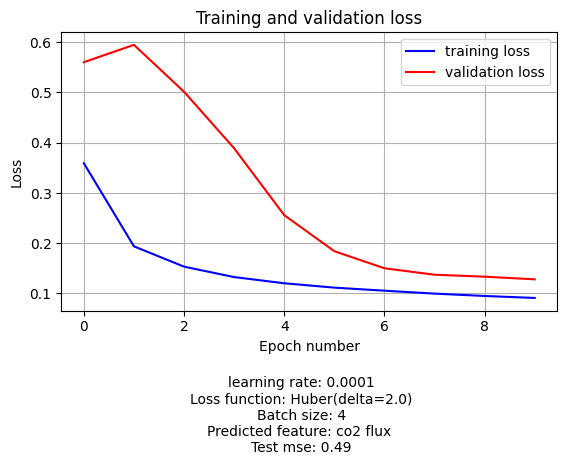

In [ ]:
plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.grid(True)
plt.legend()

plt.subplots_adjust(bottom=0.3)
plt.figtext(0.5, 0.01, f"learning rate: {lr}\nLoss function: {loss_function}\nBatch size: {str(batch_size)}\nPredicted feature: co2 flux \nTest mse: {mse:.2f}",
            wrap=True, horizontalalignment='center', fontsize=10, color='black')

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
path = folder_path + '/' + timestamp + '_training_validation_loss.png'
plt.savefig(path, format='png', dpi=300)
plt.show()  